In [3]:
from sklearn import linear_model
from arftools import *
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from matplotlib import cm
from pathlib import Path
from random import shuffle

## Load USPS data

In [4]:
data_folder = Path("usps_data")
usps_train_file, usps_test_file = data_folder / "USPS_train.txt", data_folder / "USPS_test.txt"

In [5]:
def load_usps(fn):
    with open(fn,"r") as f:
        f.readline()
        data = [[float(x) for x in l.split()] for l in f if len(l.split())>2]
    tmp=np.array(data)
    return tmp[:,1:],tmp[:,0].astype(int)

def show_usps(data):
    plt.imshow(data.reshape((16,16)),interpolation="nearest",cmap="gray")
    
def oneVone(lab1,lab2,train_data, test_data, train_lab, test_lab):
    d_train = pd.DataFrame(data = train_lab, columns=["label"])
    d_test = pd.DataFrame(data = test_lab, columns=["label"])
    
    #indexes train
    index_lab1_train = d_train[d_train["label"]==lab1].index
    index_lab2_train = d_train[d_train["label"]==lab2].index
    ind_train = np.concatenate((index_lab1_train,index_lab2_train))
    
    #indexes test
    index_lab1_test = d_test[d_test["label"]==lab1].index
    index_lab2_test = d_test[d_test["label"]==lab2].index
    ind_test = np.concatenate((index_lab1_test,index_lab2_test))

    train_indexes = sorted(ind_train, key=lambda k: random.random())
    test_indexes = sorted(ind_test, key=lambda k: random.random())

    #Données de train + labels
    trainx = np.array([train_data[i] for i in train_indexes])
    trainy = np.array([1 if train_lab[i] == lab1 else -1 for i in train_indexes]) #1 => label=lab1, -1 => label=lab2

    #Données de test + labels
    testx = np.array([test_data[i] for i in test_indexes])
    testy = np.array([1 if test_lab[i] == lab1 else -1 for i in test_indexes])
    
    return trainx, trainy, testx, testy

## Perceptron

In [6]:
from sklearn.linear_model import Perceptron

- données artificielles 2D

In [7]:
trainx,trainy =  gen_arti(nbex=1000,data_type=0,epsilon=1)
testx,testy =  gen_arti(nbex=1000,data_type=0,epsilon=1)

In [16]:
#Linear model
model = Perceptron()
model.fit(trainx,trainy)
print(f"error train: {model.score(trainx, trainy)}, error test: {model.score(testx,testy)}")

plt.figure()
plot_frontiere(trainx,model.predict,200)
plot_data(trainx,trainy)

error train: 0.897, error test: 0.901


error train: 0.892, error test: 0.912


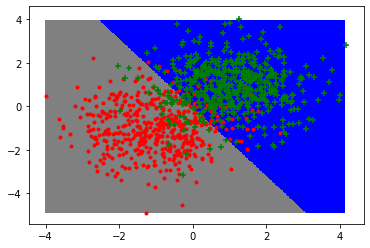

In [19]:
#Penalize linear model
penalize_model = Perceptron(penalty = "l2")
penalize_model.fit(trainx,trainy)
print(f"error train: {penalize_model.score(trainx, trainy)}, error test: {penalize_model.score(testx,testy)}")

plt.figure()
plot_frontiere(trainx,penalize_model.predict,200)
plot_data(trainx,trainy)

- USPS data 6 vs 9

In [34]:
usps_train, usps_test = load_usps(usps_train_file), load_usps(usps_test_file)
train_labels, test_labels = usps_train[1], usps_test[1]
train_data, test_data = usps_train[0], usps_test[0]

print("nb classes ->",len(np.unique(train_labels)))
print(f"nb train data ->{len(train_data)}\nnb test data -> {len(test_data)} ")

nb classes -> 10
nb train data ->7291
nb test data -> 2007 


In [35]:
data69_train, data69_train_labels, data69_test, data69_test_labels = oneVone(6,9,train_data,test_data,train_labels,test_labels)

In [38]:
#Linear model
model = Perceptron()
model.fit(data69_train,data69_train_labels)
print(f"error train: {model.score(data69_train, data69_train_labels)}, error test: {model.score(data69_test,data69_test_labels)}")

error train: 1.0, error test: 0.9971181556195965


In [39]:
#penalized linear model
model_penalized = Perceptron(penalty = "l2")
model_penalized.fit(data69_train,data69_train_labels)
print(f"error train: {model_penalized.score(data69_train, data69_train_labels)}, error test: {model_penalized.score(data69_test,data69_test_labels)}")

error train: 1.0, error test: 0.9971181556195965


## SVM et GridSearch

In [13]:
from sklearn import svm
from sklearn.model_selection import GridSearchCV

- linear Kernel

In [14]:
linear_svc = svm.SVC(probability = True, kernel='linear')
linear_svc.fit(trainx,trainy)
print(f"error train: {linear_svc.score(trainx, trainy)}, error test: {linear_svc.score(testx,testy)}")

error train: 0.903, error test: 0.911


- Gaussian Kernel

In [29]:
gsc = GridSearchCV(
        estimator=svm.SVC(kernel='rbf', probability=True),
        param_grid={
            'C': [0.1, 1, 100, 1000],
            'gamma': [0.0001, 0.001, 0.005, 0.1, 1, 3, 5]
        },scoring='neg_mean_squared_error', verbose=1)

grid_result = gsc.fit(trainx, trainy)
best_params = grid_result.best_params_

best_svc = svm.SVC(kernel='rbf',probability=True, C=best_params["C"], gamma=best_params["gamma"], verbose=1)

Fitting 5 folds for each of 28 candidates, totalling 140 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 140 out of 140 | elapsed:   12.4s finished


In [30]:
best_svc.fit(trainx,trainy)
print(f"error train: {best_svc.score(trainx, trainy)}, error test: {best_svc.score(testx,testy)}")

[LibSVM]error train: 0.903, error test: 0.904


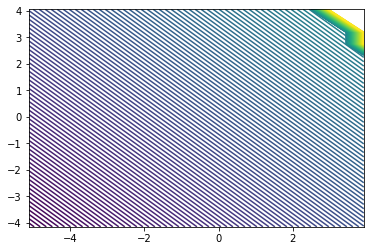

In [32]:
def plot_frontiere_proba(data, f, step =20):
    grid, x, y=make_grid(data=data, step=step)
    plt.contour(x, y, f(grid).reshape(x.shape),255)
    
plot_frontiere_proba(trainx, lambda x: best_svc.predict_proba(x)[:,0], step=20)

- Polynomial Kernel

In [12]:
polynomial_svc = svm.SVC(kernel='poly')
polynomial_svc.fit(trainx,trainy)
print(f"error train: {polynomial_svc.score(trainx, trainy)}, error test: {polynomial_svc.score(testx,testy)}")

error train: 0.896, error test: 0.9
